# Calculating $\Sigma_{10}$


In the context of the paper "[The Sloan Lens ACS Survey. VIII. The Relation between Environment and Internal Structure of Early-Type Galaxies](https://arxiv.org/pdf/0806.1056.pdf)," the projected number density of galaxies inside the tenth nearest neighbor ($\Sigma_{10}$) refers to a measure of the local galaxy density surrounding a target early-type galaxy.

To explain this concept from the paper, we need to understand how the authors calculated $\Sigma_{10}$ and its significance in studying the relationship between galaxy environment and the internal structure of early-type galaxies.

1. Calculation of $\Sigma_{10}$:
In the paper, the authors studied a sample of early-type galaxies with measured gravitational lensing effects. For each target early-type galaxy, they identified its ten nearest neighbor galaxies based on their projected angular distances. The projected angular distance is the angular separation between the target galaxy and its neighbors as seen from our perspective on Earth.

$\Sigma_{10}$ is then calculated as the number of galaxies (including the target galaxy itself) within the combined area covered by the ten nearest neighbors, divided by the total area of that region. In other words, $\Sigma_{10}$ represents the number density of galaxies in the vicinity of the target galaxy, considering the influence of its ten closest neighbors.

2. Significance of $\Sigma_{10}$:
The projected number density $\Sigma_{10}$ is a crucial parameter to study the local galaxy environment around each early-type galaxy in the sample. It provides a measure of the galaxy density on small scales, capturing the immediate gravitational influences of nearby galaxies on the target galaxy.

By analyzing the correlation between $\Sigma_{10}$ and the internal properties of early-type galaxies (such as their effective radii and velocity dispersions), the authors can explore how the local galaxy environment affects the structure and evolution of early-type galaxies. High $\Sigma_{10}$ values imply dense environments with strong gravitational interactions, which might have implications for the growth and assembly history of the early-type galaxies.

In summary, $\Sigma_{10}$ quantifies the local galaxy density surrounding each target early-type galaxy in the sample. It plays a crucial role in understanding the impact of the immediate environment on the internal properties and evolution of these galaxies, providing insights into the complex interplay between galaxy environment and galaxy structure.

Finally calculations can be made by
$$\Sigma_{10} = 10/(\pi R_{10}^2)$$

## Issue for task

https://github.com/ajshajib/BDLensing/issues/191

We've to reproduce **figure no 4** of the SLACS paper for our paper.

## Load data

In [ ]:
!pip install photutils

from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

from astropy.stats import sigma_clipped_stats
from photutils.datasets import load_star_image
from photutils.datasets import load_star_image
from photutils.aperture import CircularAperture

from google.colab import drive

drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.3 MB/s eta 0:00:00
Mounted at /content/drive


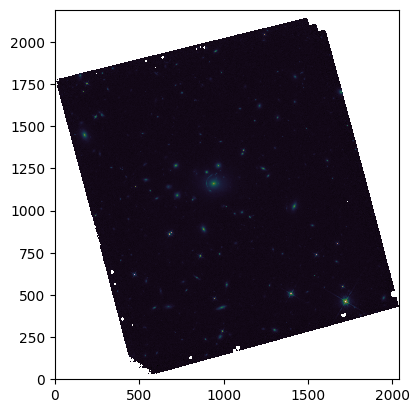

In [ ]:
data, header = fits.getdata('/content/drive/MyDrive/BDLensing/DESI-329.6820+02.9584_F140W_drz_sci.fits', header=True)

plt.imshow(np.log10(data), origin='lower',
           cmap='cubehelix', interpolation='nearest')

## Background estimation

In [ ]:
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

<ipython-input-4-4e9c120fb066>:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(data - bkg.background), origin='lower',


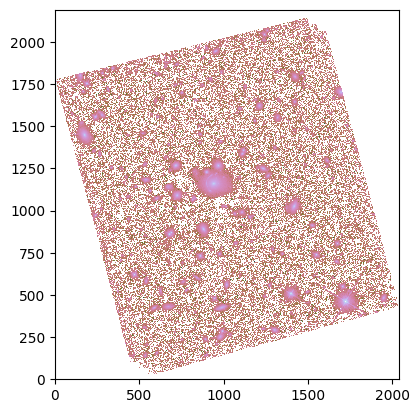

In [ ]:
plt.imshow(np.log10(data - bkg.background), origin='lower',
           cmap='cubehelix', interpolation='nearest')

## Aperture photometry

In [ ]:
np.median(bkg.background), np.median(bkg.background_rms)

(0.3169265638784865, 0.014744289724342732)

In [ ]:
bkg_subtracted_data = data - bkg.background

In [ ]:
threshold = 5 * bkg.background_rms

In [ ]:
from photutils.segmentation import detect_sources
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

In [ ]:
from photutils.segmentation import deblend_sources
segm_deblend = deblend_sources(bkg_subtracted_data, segment_map,
                               npixels=10, nlevels=32, contrast=0.001,
                               progress_bar=False)


In [ ]:
from photutils.segmentation import SourceFinder
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (2192, 2042)
nlabels: 544
labels: [  1   2   3   4   5 ... 540 541 542 543 544]


In [ ]:
from photutils.segmentation import SourceCatalog
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)

<photutils.segmentation.catalog.SourceCatalog>
Length: 544
labels: [  1   2   3   4   5 ... 540 541 542 543 544]


<ipython-input-43-b06dffcaace2>:8: RuntimeWarning: invalid value encountered in log10
  ax1.imshow(np.log10(data- bkg.background), origin='lower', cmap='cubehelix', vmin= -4, vmax= 2)


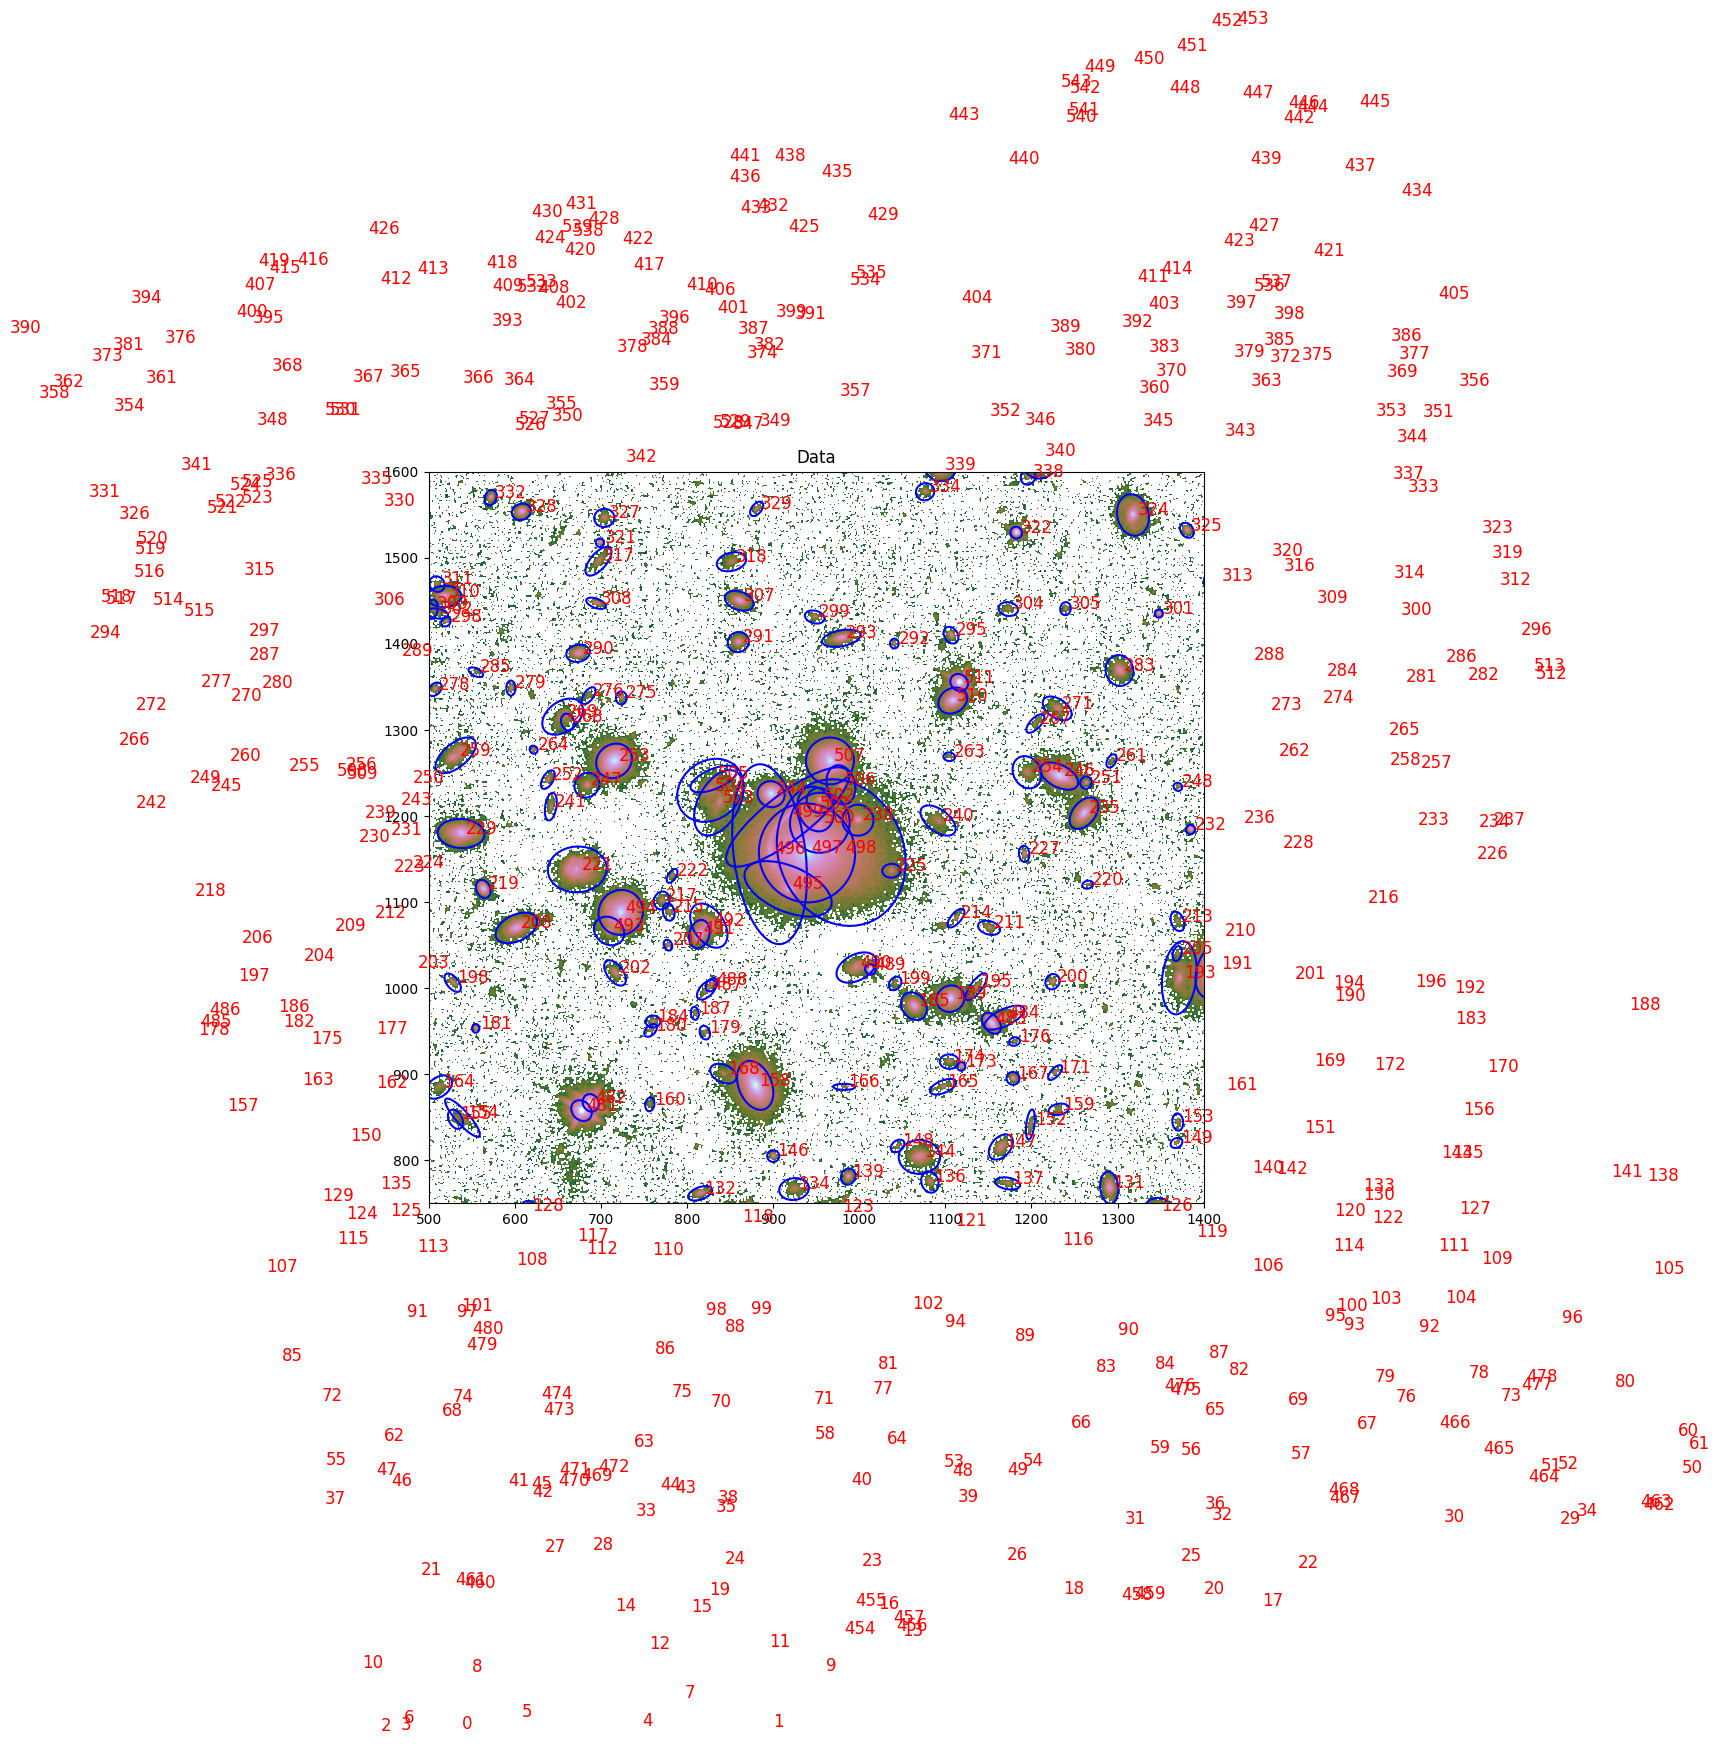

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm

norm = simple_norm(data, 'sqrt')

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(np.log10(data- bkg.background), origin='lower', cmap='cubehelix', vmin= -4, vmax= 2)
ax1.set_title('Data')

cat.plot_kron_apertures(ax=ax1, color='blue', lw=1.5);

for i in range(len(cat)):
    ax1.text(cat.xcentroid[i]+5, cat.ycentroid[i],
             f'{i}', c='r', fontsize=12
             #transform=ax1.transAxes
             )
# cat.plot_kron_apertures(ax=ax2, color='white', lw=1.5);

ax1.set_xlim(800-300, 1100+300)
ax1.set_ylim(1050-300, 1300+300)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)


In [ ]:
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'  # optional format
tbl['ycentroid'].info.format = '.2f'
tbl['kron_flux'].info.format = '.2f'

In [ ]:
# close galaxies

id_central = 498 # object id of your central deflector/lens
highest_id = 511

x0 = tbl['xcentroid'].value[id_central]
y0 = tbl['ycentroid'].value[id_central]
f0 = tbl['kron_flux'].value[id_central]

close_galaxies = []
dist_galaxies = []
flux_galaxies = []
for i in range(len(tbl)):
    if i == highest_id:
        continue
    x = tbl['xcentroid'].value[i]
    y = tbl['ycentroid'].value[i]
    f = tbl['kron_flux'].value[i]
    if (np.sqrt((x-x0)**2 + (y-y0)**2) < 20/0.06) & (f > f0*0.01):
        print(i)
        close_galaxies.append(i)
        flux_galaxies.append(f)
        dist_galaxies.append(np.sqrt((x-x0)**2 + (y-y0)**2))
print("Number of Close galaxies:", len(close_galaxies))

158
185
189
202
221
225
235
238
240
244
246
247
253
254
271
291
293
307
483
484
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
510
Number of Close galaxies: 40


In [ ]:
from astropy.wcs import WCS

def distance_arcsec(x):
    wcs = WCS(header)

    pixel_distance = x

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

In [ ]:
import pandas as pd

n_sys = 11  #number of galaxies detected inside your lensing system

df = pd.DataFrame({'Distance(pixels)': dist_galaxies})

df.set_index(pd.Index(close_galaxies), inplace=True)

df['Distance(arcsec)'] = distance_arcsec(df['Distance(pixels)'])
df['Flux'] = flux_galaxies

# Sort the DataFrame based on 'Distance'
df_sorted = df.sort_values(by='Distance(pixels)')

# Exclude the lensing system members
df_sys_removed = df_sorted.iloc[n_sys:]

# first 10 galaxies
df_10 = df_sys_removed.iloc[:10]

# first 20 galaxies
df_20 = df_sys_removed.iloc[:20]

print(df_20)

     Distance(pixels)  Distance(arcsec)         Flux
244        106.014840          8.481187   765.719745
507        107.246132          8.579691  1351.754722
240        118.516728          9.481338    28.071728
490        134.604977         10.768398    58.078983
489        139.803424         11.184274   152.524681
503        153.467490         12.277399   130.124379
504        168.386910         13.470953   133.860456
505        170.995617         13.679649    25.962744
492        175.559101         14.044728   107.295200
491        190.027553         15.202204   205.562985
185        197.312590         15.785007   123.632877
189        211.848977         16.947918   346.428497
510        218.992863         17.519429   343.183833
254        235.120948         18.809676    26.471480
293        248.930301         19.914424    88.474943
483        264.035810         21.122865   285.864354
494        265.241499         21.219320  1220.768408
246        268.317211         21.465377   749.

# $R_{10}$, $R_{20}$ and $\Sigma_{10}$, $\Sigma_{20}$ Calculation

In [ ]:
R_10 = df_10.iloc[9, df.columns.get_loc('Distance(arcsec)')]
R_20 = df_20.iloc[19, df.columns.get_loc('Distance(arcsec)')]
Sigma_10 = 10/(np.pi*R_10**2)
Sigma_20=20/(np.pi*R_20**2)

print("R 10:", R_10)
print("R 20:", R_20)
print("Sigma 10:", Sigma_10)
print("Sigma 20:", Sigma_20)

R 10: 15.202204268394153
R 20: 21.771418884363012
Sigma 10: 0.013773268055491745
Sigma 20: 0.013430947622606014


In [ ]:
from photutils.aperture import CircularAnnulus, CircularAperture

galaxies_10 = df_10.index.tolist()

print(galaxies_10)

positions = [(cat.xcentroid[i], cat.ycentroid[i]) for i in galaxies_10]

aperture_10 = CircularAperture(positions, r=20.0)

[244, 507, 240, 490, 489, 503, 504, 505, 492, 491]


In [ ]:
from photutils.aperture import CircularAnnulus, CircularAperture

galaxies_20 = df_20.index.tolist()

print(galaxies_20)

positions = [(cat.xcentroid[i], cat.ycentroid[i]) for i in galaxies_20]

aperture_20 = CircularAperture(positions, r=20.0)

[244, 507, 240, 490, 489, 503, 504, 505, 492, 491, 185, 189, 510, 254, 293, 483, 494, 246, 484, 291]


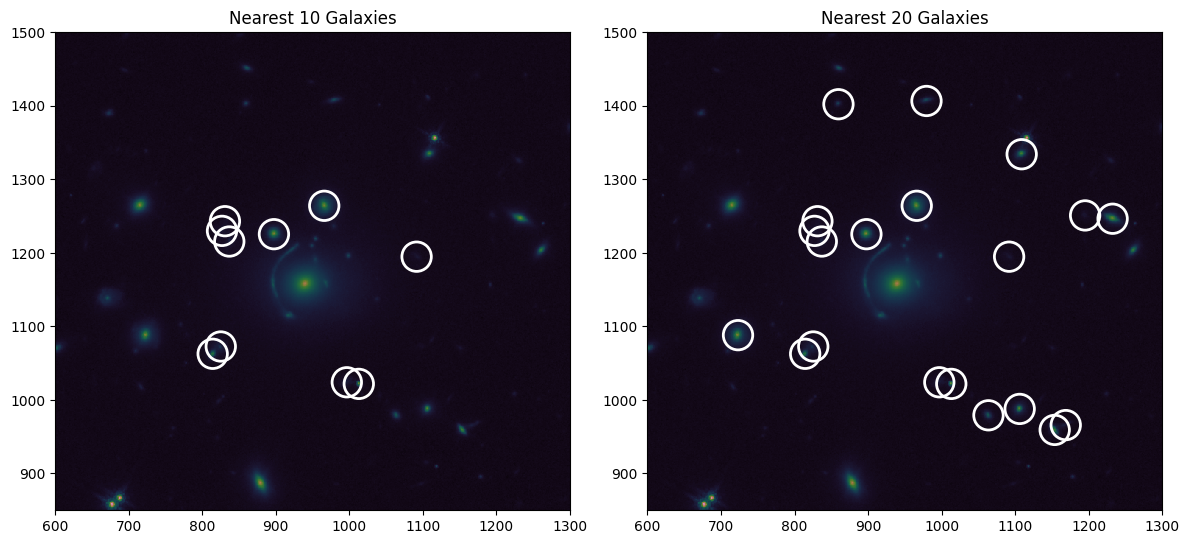

In [ ]:
# Create two separate plots
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the nearest 10 galaxies from df_10 in the first subplot
axs[0].imshow(np.log10(data), interpolation='nearest', origin='lower', cmap='cubehelix')
aperture_10.plot(color='white', lw=2, ax=axs[0])

axs[0].set_xlim(800-200, 1100+200)
axs[0].set_ylim(1050-200, 1300+200)
axs[0].set_title('Nearest 10 Galaxies')

# Plot the nearest 20 galaxies from df_20 in the second subplot
axs[1].imshow(np.log10(data), interpolation='nearest', origin='lower', cmap='cubehelix')
aperture_20.plot(color='white', lw=2, ax=axs[1])
axs[1].set_xlim(800-200, 1100+200)
axs[1].set_ylim(1050-200, 1300+200)
axs[1].set_title('Nearest 20 Galaxies')


plt.tight_layout()
plt.show()